<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_resnet18_Balanceo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Binario

## Librerías

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip


2022-06-16 15:10:54 URL:https://ucca28dead25226a7c97ba3d2d11.dl.dropboxusercontent.com/cd/0/inline2/BnV1v80EG-B8YvCOQQsiIY-Bhb2xxtile2cYUc5qHgPqeI-SUTaWe0NjkkhJEjL7XeiyouoYIXMHT2RaxV1MwNdezFr3YVfq-iIoq2HvX-iBMLWDO3t1fEMVZ7XvVnjPAgAhuHRntj0JPRQDe50gM3cP4vk-KrKUzeuK1ts-zYlbJcIv02Tk-48a8bB46_g8WwvOPwuGThzaGiDVWZZdS8oDwsnSACyBt01QGUQrNJrSDzSoZ-WA9zFO9L1Kv3yIBGa2gNSn_Rh1I676RH5UYGULn7V1Icr-2YqygLDQl-qAa1YfKb04ESlkO7FwpWGcPUmGFmCwu6Zg2tXlnhW_N37ONvVJxPlWa21vh3D7lfTYmeJH3NoCC9EQgVU2L_CarfBnOrJ5Qaw5o15EverFSPokKW_fNLVgxKRV-oTnOm8BMA/file [138777773/138777773] -> "train.zip" [1]
2022-06-16 15:10:58 URL:https://uc74486bd7f8607eb7a719c39d65.dl.dropboxusercontent.com/cd/0/inline2/BnW4HpH2imQ8jfYr4-ApuiJgvxuiIGq5iRSR0NUtsA7qiQBpyJ2lVxccL-2E33_svc-8dafoRhX0_nFPdTaa-7PoswZ5x6Hzqk52X1-v816e__pdeGmixZ7zY5f6p8WB2m493v-9q_6ZdBeHTp2hj59y5ei5gfwDdKmW3Jm49zl77N7DlFVEMoADP9WYps_KXR0M4TnB0_Qqftk_zYku67OqY27C80WaKe77yw4-yzarK38VLAa1dZzNyvPjJWUVXvK8QVXRI3f2xMkAOM5DnTcpaSzGNXW4gZikdTihnNZN3jbvbYJwMSpSIlsj0KoopOC

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [45]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [46]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [47]:
path = Path('dataset/')

In [48]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [49]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [50]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [51]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Ahora en la función moverImg() debemos copiar las imagenes en vez de moverlas ya que algunas se van a duplicar. También debemos dar un nombre random cada vez para conseguir que se dupliquen y no se sobreescriban cada vez.

In [52]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

## Balanceo

### Balanceando el conjunto de entrenamiento:

Duplicaremos de forma aleatoria las intancias del dataframe de train, después moveremos la imágenes en función del dataset.


In [53]:
from sklearn.utils import resample

In [54]:
df_majority = df_train[df_train.Disease_Risk==1] #mayoria de instacias con enfermedad respecto a sin ella.
df_minority = df_train[df_train.Disease_Risk==0]

Para dejar las dos clase iguales en una debemos reducir 559 instancias y para la minoritaria aumentar 559. De esta forma nos quedaremos con 960 instancias.

In [55]:
len(df_majority)

1519

In [38]:
len(df_minority)

401

In [72]:
# Aumentar la muestra de la clase minoritaria
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=960,    # número de muestras de la clase mayoritaria
                                 random_state=42) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=960,     # número de muestras de la clase minoritaria
                                 random_state=42) # semilla para que los datos sean reproducibles
                               
# Combinar el nuevo grupo con el grupo original mayoritario
df_train = pd.concat([df_majority_downsampled, df_minority_upsampled])
df_train = df_train.reset_index(drop=True)

# Mostrar el número de instancias en cada clase
df_train.Disease_Risk.value_counts()

1    960
0    960
Name: Disease_Risk, dtype: int64

In [73]:
len(df_minority_upsampled.ID.unique())

359

**Ahora que ya tenemos la estructura deseada empezamos a construir el modelo:**

In [74]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [15]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

640

In [77]:
len(Path('dataset/train/normal').ls()) #401

960

## Cargando el dataset

In [78]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [79]:
dls = db.dataloaders(path,bs=128)

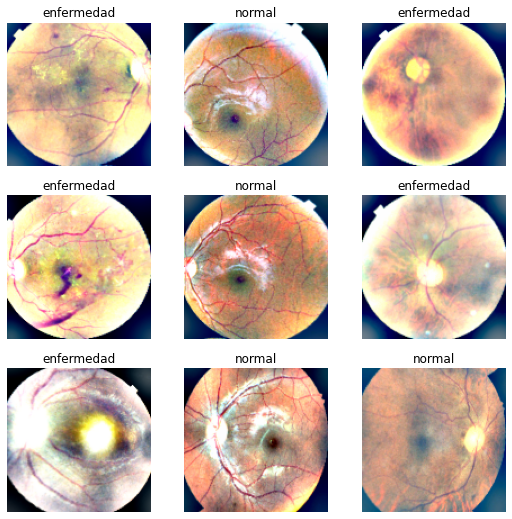

In [80]:
dls.show_batch()

In [81]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')  
]

In [82]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.012022644281387329, steep=0.005248074419796467, valley=0.0004786300996784121, slide=0.005248074419796467)

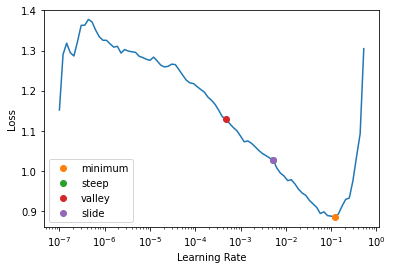

In [83]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,time
0,0.860907,2.421910,0.529688,00:09


Better model found at epoch 0 with valid_loss value: 2.4219095706939697.


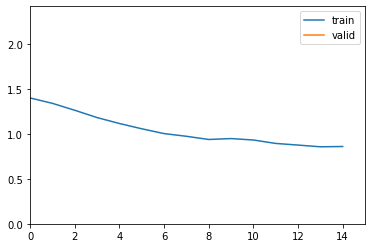

epoch,train_loss,valid_loss,accuracy,time
0,0.624599,1.082194,0.751562,00:12
1,0.529296,0.717159,0.764063,00:09
2,0.465588,0.767571,0.757812,00:09
3,0.421454,0.605431,0.809375,00:09
4,0.372590,0.616400,0.818750,00:09
5,0.343189,0.437584,0.851562,00:09
6,0.311006,0.575384,0.832812,00:09
7,0.276358,0.719772,0.806250,00:09
8,0.253310,0.565641,0.854688,00:09
9,0.234294,0.642545,0.834375,00:11


Better model found at epoch 0 with valid_loss value: 1.0821940898895264.


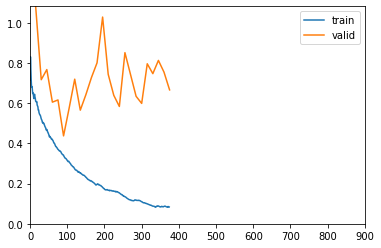

Better model found at epoch 1 with valid_loss value: 0.7171590328216553.
Better model found at epoch 3 with valid_loss value: 0.6054314374923706.
Better model found at epoch 5 with valid_loss value: 0.4375841021537781.
No improvement since epoch 5: early stopping


In [84]:
learn.fine_tune(60,base_lr=5e-3)

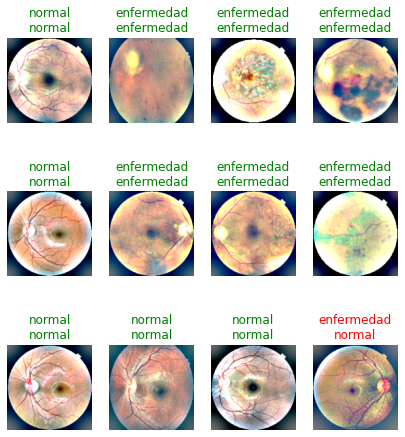

In [85]:
learn.show_results(max_n=12, figsize=(7,8))

Exportamos el modelo

In [86]:
learn.to_fp32()
learn.export('Binario_resnet18_Balanceo.pkl')

## Evaluando el modelo

In [87]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [88]:
learn.dls = dlsTest

El valor de la función de perdida es de 0.34 y su accuracy es del 80%.

In [89]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.848437488079071.


(#2) [0.3245898485183716,0.848437488079071]

## Interpretación del modelo

In [90]:
learn.dls=dls

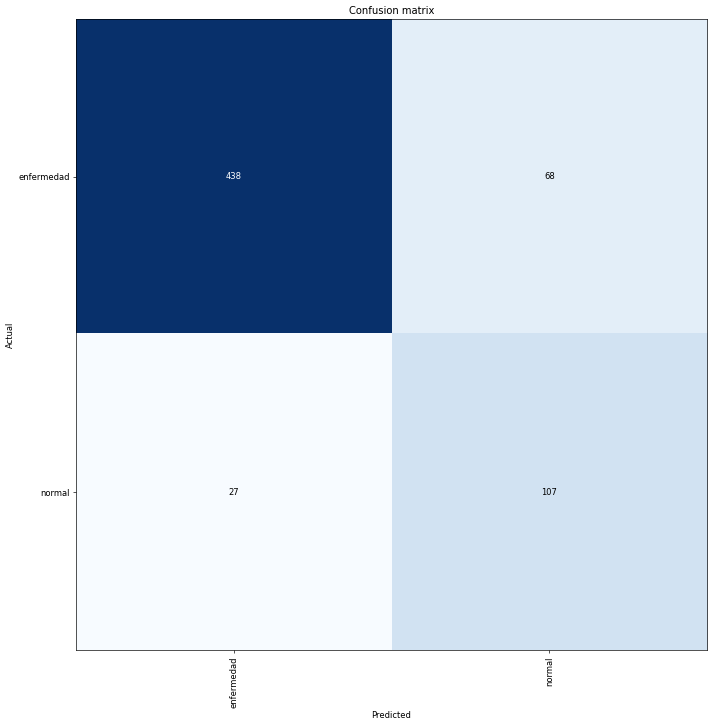

In [91]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)